In [59]:
%matplotlib inline
import pandas as pd
import transit
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
from scipy.interpolate import LSQUnivariateSpline
from scipy import stats

First I read the data that has been processed with IDL (Change that!). It contains a folded light curve with time in days and relative flux.

In [60]:
data = pd.read_csv('./Readingdata/PDCMAP.csv')
time = np.array(data['Time'])
iniflux = np.array(data['Flux'])
quarter = np.array(data['Quarter'])

Here I remove the effects of stellar activity using a cubic spline

In [61]:
goodquart = np.unique(quarter)

ndays = 4.0

flux = iniflux

for i in goodquart:
    if i> 1 and i < 17:
        goodp = quarter == i
        t = time[goodp]
        f = iniflux[goodp]
        
        knot_w = ndays 
        first_knot_i = np.where((t - t[0]) >= ndays)[0][0]
        last_knot_i = np.where((t[-1]-t) >= ndays)[0][-1]
        
        knots = np.arange(t[first_knot_i],t[last_knot_i],knot_w)
        spline = LSQUnivariateSpline(t,f,knots,k=3)
        fit = spline(t)
        
        flux[goodp] = flux[goodp]/fit

I define a few properties of the planet and the star, some of them will be fixed during the computations, some others not

In [119]:
## Planet properties
depth = 0.000174 #initial guess

period =  0.6892099
t0 = 53.191352

ecc = 0.0
b = 0.5 

##Star properties (from Ellen)
mass = 1.00
masserr = 0.04
radius = 1.09
radiuserr = 0.09
u1 = 0.44 #Claret
u2 = 0.24 #Claret
diffLD = u1-u2

# Kepler cadence
tKep = 29.42/(60.0*24.0)

allfixed = [period, ecc,  mass, masserr, radius, radiuserr, diffLD, tKep]

Now I fold the light curve using the best fit period and t0 from Sanchis-Ojeda et al. 2014

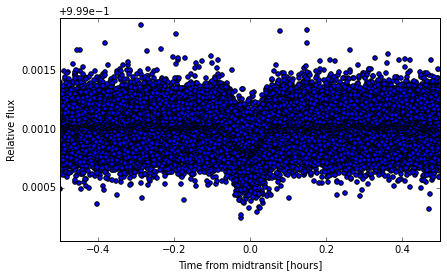

In [120]:
dt = time-t0 
phase = (dt % period)/period
movephase = phase > 0.5
phase[movephase] = phase[movephase]-1.0

bin_means, bin_edges, binnumber = stats.binned_statistic(phase, flux, statistic='median',
                                                         bins = np.round(period*24.0*60.0))

bin_centers = 0.5*(bin_edges[0:-1] + bin_edges[1:])
# Plot the results
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,2,1)
ax.scatter(phase,flux)
plt.xlim([-0.5, 0.5]) 
plt.ylim([1-depth*5.5, depth*5.5+1]) 
ax.set_xlabel('Time from midtransit [hours]')
ax.set_ylabel('Relative flux')
ax.scatter(bin_centers, bin_means) 

transitwindow = 2.0/(24*period)
selectedp = np.abs(bin_centers) < transitwindow
errorLC = np.std(bin_means[~selectedp]) # outside of transit

timeLC = period*bin_centers[selectedp]
fluxLC = bin_means[selectedp]

Here I define a likelihood function that will help me find the best transit parameters and their uncertainties

In [121]:
def lnlike(theta, timeLC, fluxLC, errorLC, allfixed):
    """
    Calculates the log of the likelihood of the transit model being the right model given the following parameters:
    theta[0] = pdepth = (Rp/Rs)^2
    theta[1] = pb = the impact parameter 
    theta[2] = pt0 = the time of transit
    theta[3] = sigma = an additional white noise term
    theta[4] = u1 + u2 = sum of LD coefficients
    theta[5] = pmass = the mass of the star (controlled via gaussian prior)
    theta[6] = pradius = the radius of the star (controlled via gaussian prior)
    theta[7] = f0 = the out of eclipse flux
    """
    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
    period, ecc, mass, masserr, radius, radiuserr, diffLD, tKep = allfixed
    u1 = 0.5*(sumLD+diffLD)
    u2 = sumLD-u1
    s = transit.System(transit.Central(mu1=u1, mu2=u2, mass = pmass, radius = pradius ))
    body = transit.Body(r=np.sqrt(pdepth)*pradius, period=period, t0=pt0, b=np.abs(pb), e=ecc)
    s.add_body(body)
    inv_sigma2 = 1.0/(errorLC**2 + sigma**2)
    ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=4)
    ftheo = ftheo-1+f0
    return -0.5*(np.sum((fluxLC-ftheo)**2*inv_sigma2 - np.log(inv_sigma2)) + ((pmass-mass)/masserr)**2
            + ((pradius-radius)/radiuserr)**2)

In [122]:
def lnprior(theta):
    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
    if (0.4 < sumLD < 1.0) and (0 <= pb <1.0) and (0 <= sigma):
        return 0.0
    return -np.inf

In [123]:
def lnprob(theta, timeLC, fluxLC, errorLC, allfixed):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, timeLC, fluxLC, errorLC, allfixed)

In [124]:
nll = lambda *args: -lnprob(*args)
result = op.minimize(nll, [1.2*depth, b, 0.0, 0.0, 0.6, mass, radius, 1.0], 
                     args=(timeLC, fluxLC, errorLC, allfixed), options={'disp': True}, method='Nelder-Mead')
depth_ml, b_ml,  t0_ml, sigma_ml, sumLD_ml, mass_ml, radius_ml, f0_ml  = result["x"]
u1_ml = 0.5*(sumLD_ml + diffLD)
u2_ml = sumLD_ml-u1_ml

Optimization terminated successfully.
         Current function value: -2432.888414
         Iterations: 722
         Function evaluations: 1107


In [125]:
# Compute the light curve integrated over a Kepler long cadence
# exposure time.
s = transit.System(transit.Central(mu1=u1_ml, mu2=u2_ml, mass = mass_ml, radius = radius_ml ))
body = transit.Body(r=np.sqrt(depth_ml)*radius_ml, period=period, t0=t0_ml, b=b_ml, e=ecc)
s.add_body(body)
t = np.arange(-1, 1, tKep*0.01)
f = s.light_curve(t, texp=tKep, tol=1e-08, maxdepth=4)
f = f-1.0 + f0_ml

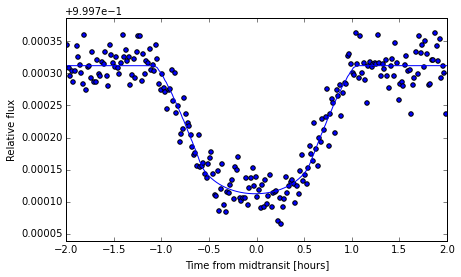

In [126]:
# Plot the results
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,2,1)
ax.scatter(24.0*timeLC,fluxLC)
plt.xlim([-2.0, 2.0]) 
plt.ylim([1-depth*1.5, depth*0.5+1]) 
ax.set_xlabel('Time from midtransit [hours]')
ax.set_ylabel('Relative flux')
ax.plot(24.0*t, f)

In [127]:
depth_ml, b_ml,  t0_ml, sigma_ml, sumLD_ml, mass_ml, radius_ml

(0.00016689066322115255,
 0.42747787164420337,
 -0.00053038589932392129,
 4.8787192645168214e-06,
 0.78507302683097135,
 1.0009513309362326,
 1.0873941918194667)

With the best fit solution, we can know obtain a folded light curve for each quarter and obtain a transit time

In [128]:
allfixed2 = [period, ecc, diffLD, tKep, depth_ml, b_ml, sumLD_ml, mass_ml, radius_ml]

In [129]:
def lnlikeind(theta, timeLC, fluxLC, errorLC, allfixed):
    """
    Calculates the log of the likelihood of the transit model being the right model given the following parameters:
    theta[0] = pt0 = the time of transit of the folded light curve
    theta[1] = sigma = an additional white noise term
    theta[2] = f0 = the out of eclipse flux
    theta[3] = df_dt = the out of eclipse flux slope
    """
    pt0, sigma, f0, df_dt = theta
    period, ecc,diffLD, tKep, pdepth, pb, sumLD,  pmass, pradius = allfixed
    u1 = 0.5*(sumLD+diffLD)
    u2 = sumLD-u1
    s = transit.System(transit.Central(mu1=u1, mu2=u2, mass = pmass, radius = pradius ))
    body = transit.Body(r=np.sqrt(pdepth)*pradius, period=period, t0=pt0, b=np.abs(pb), e=ecc)
    s.add_body(body)
    inv_sigma2 = 1.0/(errorLC**2 + sigma**2)
    ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=4)
    ftheo = ftheo-1+f0 + df_dt*timeLC
    return -0.5*(np.sum((fluxLC-ftheo)**2*inv_sigma2 - np.log(inv_sigma2)))

Optimization terminated successfully.
         Current function value: -3209.252372
         Iterations: 74
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -3192.404326
         Iterations: 63
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -3189.301567
         Iterations: 61
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -3187.055513
         Iterations: 74
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -3211.232353
         Iterations: 73
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -3174.943096
         Iterations: 82
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: -3220.557392
         Iterations: 77
         Function evaluations: 187

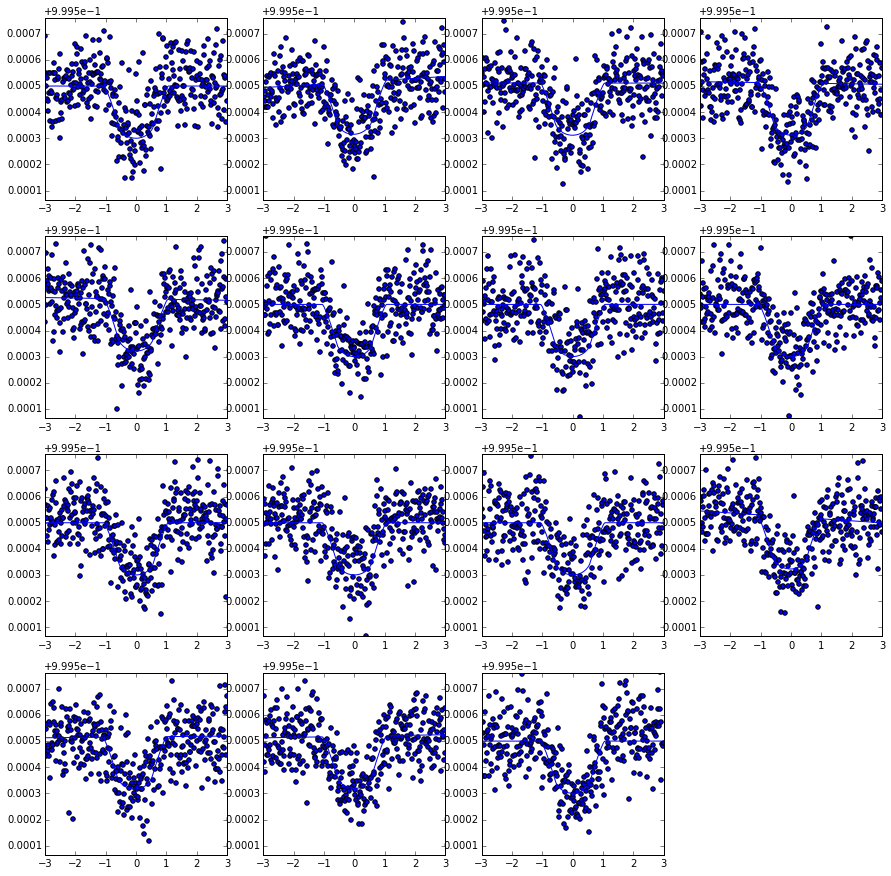

In [140]:
epochs = []
timeoftrans = []
uncertainty = []

fig = plt.figure(figsize=(15,15))

numplots = 0

for quart in goodquart:
    if quart > 1 and quart < 17:
        selp = quarter == quart
        approxt = np.median(time[selp])
        theepoch= np.round((approxt-t0)/period)
        prelimt0 = theepoch*period + t0
        dt = time[selp]-t0 
        phase = (dt % period)/period
        movephase = phase > 0.5
        phase[movephase] = phase[movephase]-1.0

        bin_means, bin_edges, binnumber = stats.binned_statistic(phase, flux[selp], statistic='median',
                                                         bins = np.round(period*24.0*60.0))
        bin_centers = 0.5*(bin_edges[0:-1] + bin_edges[1:])
        selectedp = np.abs(bin_centers) < 1.5*transitwindow
        errorLC = np.std(bin_means[~selectedp]) # outside of transit

        timeLC = period*bin_centers[selectedp]
        fluxLC = bin_means[selectedp]
        
        
        nll = lambda *args: -lnlikeind(*args)
        result = op.minimize(nll, [0.0, 0.01*errorLC,1.0, 0.0], 
                     args=(timeLC, fluxLC, errorLC, allfixed2), options={'disp': True}, method='Nelder-Mead')
        t0_ml, sigma_ml, f0_ml, df_dt_ml  = result["x"]

        s = transit.System(transit.Central(mu1=u1_ml, mu2=u2_ml, mass = mass_ml, radius = radius_ml ))
        body = transit.Body(r=np.sqrt(depth_ml)*radius_ml, period=period, t0=t0_ml, b=b_ml, e=ecc)
        s.add_body(body)
        t = np.arange(-1, 1, tKep*0.01)
        f = s.light_curve(t, texp=tKep, tol=1e-08, maxdepth=4)
        f = f-1.0 + f0_ml + df_dt_ml*t
        
        
        numplots +=1    
        ax = fig.add_subplot(4,4,numplots)
        ax.scatter(24.0*timeLC, fluxLC)
        plt.xlim([-3.0, 3.0]) 
        plt.ylim([1-depth*2.5, depth*1.5+1]) 
        ax.plot(24.0*t, f)
        
        epochs.extend([theepoch])
        timeoftrans.extend([prelimt0+t0_ml])
        uncertainty.extend([0.001])

        
print epochs
print timeoftrans

Now we can fit the timings to obtain the final epoch 

In [145]:
values, covariancemetric = op.curve_fit(lambda x, a, b: x*a +b, epochs, timeoftrans, sigma=uncertainty)
print values
print np.sqrt(covariancemetric[0, 0]), np.sqrt(covariancemetric[1, 1])

[  0.68920949  53.19145458]
3.3389831357e-07 0.000409098090367


The planet radius in units of the Earth's radius is:

In [18]:
planetrad_mcmc

(1.4961052545318019, 0.163440341642211, 0.10416822881252963)

The inverse of the scaled semi-major axis is:

In [19]:
r_a_mcmc

(0.32479621970019618, 0.026223189829603921, 0.017213108006102207)

In [20]:
 np.savetxt('bestfitinitial.txt', (depth_mcmc, b_mcmc,  t0_mcmc, sigma_mcmc, sumLD_mcmc, mass_mcmc,
                                    radius_mcmc, f0_mcmc, planetrad_mcmc,r_a_mcmc), fmt='%.4e', delimiter='   ',
            header = """Parameters obtained from a fit to the Kepler data. The first column represents the 50% percentile
            of the MCMC posterior distribution, whereas the second (third) represents the +1 (-1) sigma uncertainty. In row 
            order, the parameters are: Depth, Impact parameter, time of transit, Flux uncertainty, Sum of LD coefficients, 
            Mass of the star, Radius of the star (gaussian priors on both), out of eclipse flux, Planet radius, R_s/a.""") 